# Report on Ensemble Empirical Mode Decomposition (EEMD) method

This technique aims at decomposing an input power signal into trend, seasonality and random components. The trend component is then used for computing the degradation factor (or equivalently the degradation rate). The methodology has the three following steps:
- First, we apply EEMD algorithm. This step takes as input a power signal and outputs a set of oscillatory functions (see below for more details).
- Second, we obtain the spectral representation of the oscillatory functions by Fourier transform (FT). According to their power pectrum, the oscillatory functions are grouped into trend, seasonal and random components. 
- Finally, we estimate the degradation factor (or equivalently the degradation rate) from the trend component.

EEMD is a data-driven, adaptive decomposition method which is a generalization of the Empirical Mode Decomposition (EMD) method. EMD is a technique for decomposing an input signal into a set of oscillatory components named Intrinsic Mode Functions (IMFs). The IMFs must satisfy the following two conditions:
1. the number of extrema and the number of zero-crossings must be the same or differ at most by one
2. at any point, the mean value of the envelope defined by the local maxima and the envelope defined by the local minima is zero.

For a description of the EMD algorithm see [[1]](https://srcole.github.io/2016/01/18/emd/) or [[2]](https://www.hindawi.com/journals/jece/2008/293056/). EEMD uses *M* slightly perturbed copies of the input signal, and applies EMD to each of these copies. Thus, obtaining one set of IMFs for each perturbed signal. The output set of IMFs is obtained by averaging over the ensemble of IMFs, in this way the noise cancels out.

**Open questions**

**Conclusions/Summary**

**Resources/Bibliograpy**

- [1] [Empirical Mode Decomposition (EMD)](https://srcole.github.io/2016/01/18/emd/)
- [2] [EMD](https://www.hindawi.com/journals/jece/2008/293056/)
- [3] [Ensemble Empirical Mode Decomposition (EEMD)](https://www.worldscientific.com/doi/abs/10.1142/S1793536909000047)
- [4] [EEMD + LSTM](https://link.springer.com/article/10.1007/s11269-019-02345-1)

In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline
from PyEMD import EMD, EEMD
from scipy import fftpack

In [2]:
# Load data 
csv_index   = 12
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_basic    = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)

time for importing dataframe: 0.69 seconds


In [3]:
# Preprocess data
df_basic = downsample_dataframe(df_basic, night_method='basic', clip_method='universal')

In [4]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [5]:
df_basic.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,373.200000,167.904000,7.360400,0.0,0.999985,1.0,1.0,759.612000
2015-01-02 00:00:00-05:00,378.257028,169.899598,7.328112,0.0,0.999959,1.0,1.0,760.763052
2015-01-03 00:00:00-05:00,380.512000,170.740000,7.291200,0.0,0.999935,1.0,1.0,761.804000
2015-01-04 00:00:00-05:00,383.091633,171.645418,7.250996,0.0,0.999905,1.0,1.0,762.840637
2015-01-05 00:00:00-05:00,385.932540,172.666667,7.217063,0.0,0.999880,1.0,1.0,763.873016


Text(0.5, 0, 'time [days]')

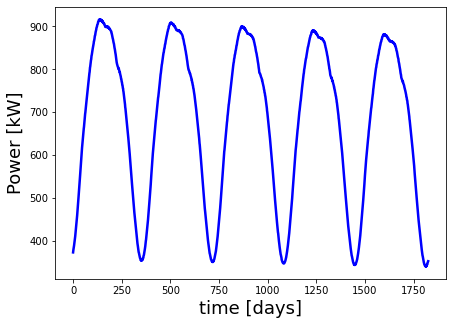

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_basic.Power.to_numpy(), color="blue", ls="-", lw=2.5)
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
#ax.set_xlim([85, 125])
#ax.set_ylim([800, 900])

## Further preprocess step

The input signal is the logarithmn of the daily power. In this way, the variability of the signal is reduced.

Text(0.5, 0, 'time [days]')

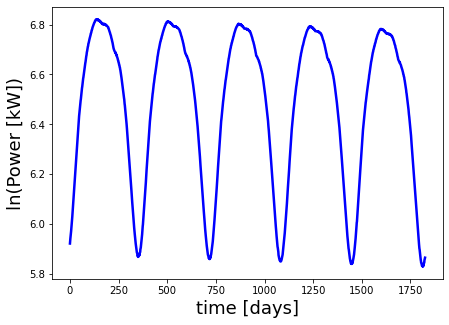

In [8]:
x_power = np.log(df_basic.Power.to_numpy())
label   = df_basic.Degradation.to_numpy()

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x_power, ls="-", color="b", lw="2.5")
ax.set_ylabel("ln(Power [kW])", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)

## EEMD

**First step: decomposition of input power signal into set of IMFs, i.e.**

\begin{equation}
{\rm Input\, power\, signal} = \sum_i eIMF_i + {\rm residual}
\end{equation}

- Sometimes the last IMF is monotonically increasing with time - include a repeat if this happens? Should we worry about this?

In [38]:
# Initialize EEMD class
eemd   = EEMD(spline_kind="cubic", extrema_detection="parabol", trials=200, noise_width=0.01)
# trials = number of ensemble members M (# of copies of input signal)
# noise is added to each copied input signal -> noise_width =  standard deviation of Gaussian noise

# run eemd / eIMFs contains the final set of IMFs
eIMFs  = eemd.eemd(x_power)
_, res = eemd.get_imfs_and_residue()
nIMFs  = eIMFs.shape[0]

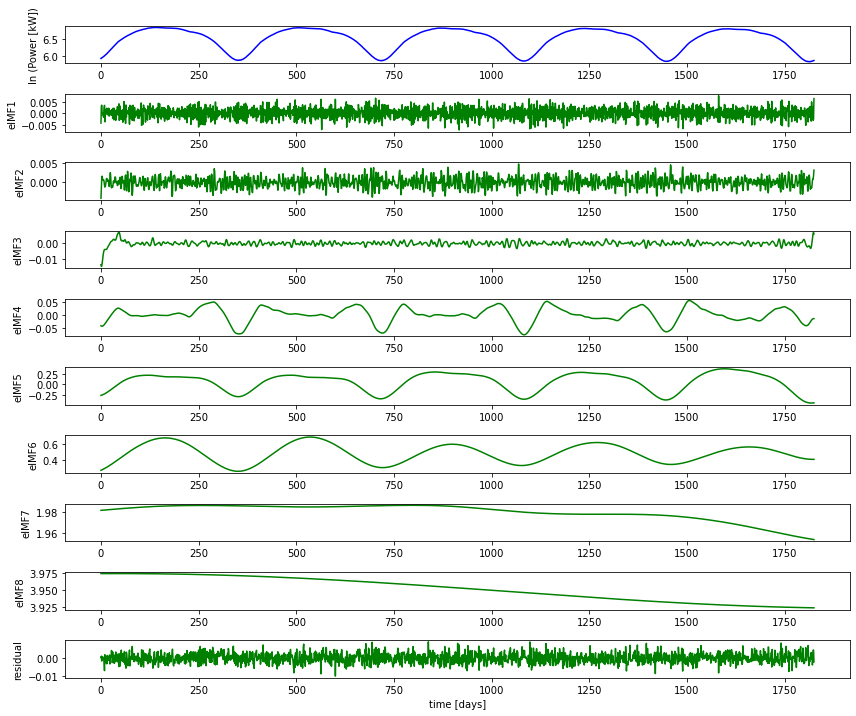

In [39]:
fig, ax = plt.subplots(nIMFs+2, 1, figsize=(12, 10))
ax[0].plot(x_power, "blue")
ax[0].set_ylabel("ln (Power [kW])")

for i in range(nIMFs):
    ax[i+1].plot(eIMFs[i], color="green")
    ax[i+1].set_ylabel("eIMF%i" %(i+1))
ax[nIMFs+1].plot(res, color="g")
ax[nIMFs+1].set_ylabel("residual")
ax[nIMFs+1].set_xlabel("time [days]")
plt.tight_layout()

**Second step: FT each IMF**

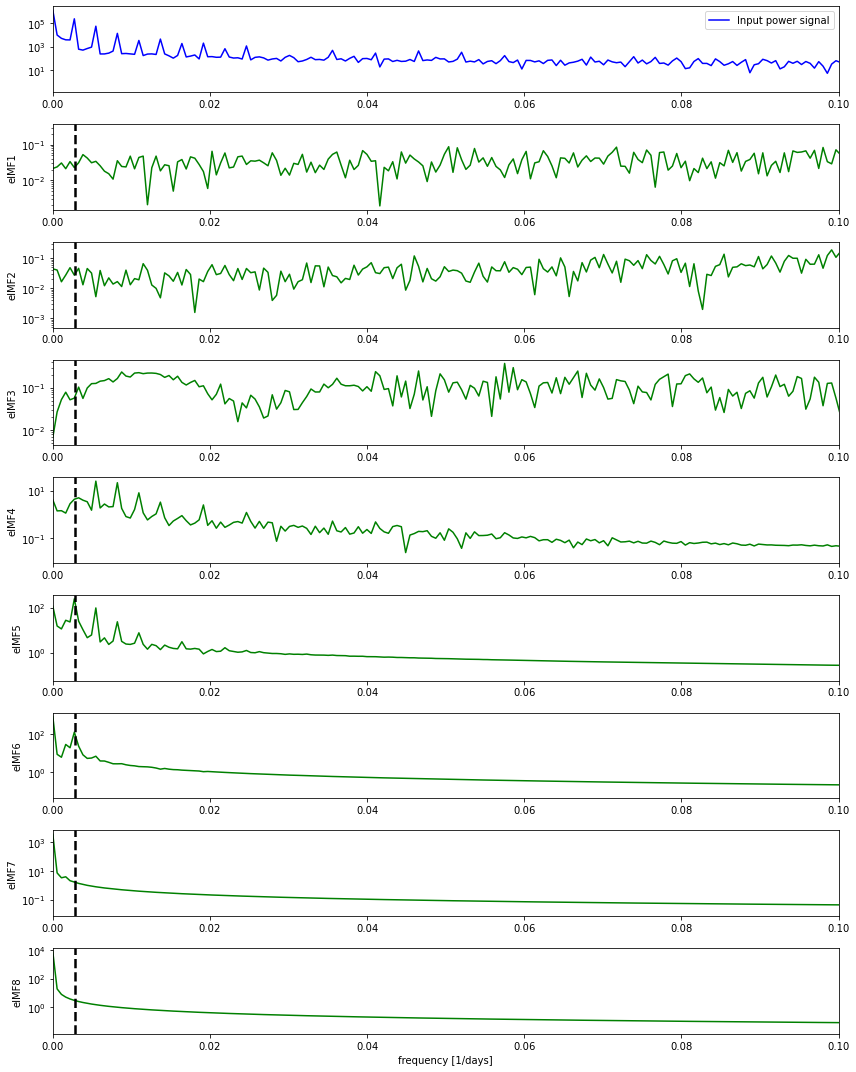

In [40]:
# Calculate FTs and plot them
plt.figure(figsize=(12, 15))

plt.subplot(nIMFs+1, 1, 1)
box_length  = df_basic["Power"].to_numpy().size
power_fft   = fftpack.fft(df_basic["Power"].to_numpy()) # FT input power signal
sample_freq = fftpack.fftfreq(box_length, d=1)
plt.plot(sample_freq[0:int(box_length/2)], np.abs(power_fft[0:int(box_length/2)]), color="blue", label="Input power signal")
plt.yscale("log")
plt.xlim([0.0, 0.1])
plt.legend()

power_IMFs = np.ones((nIMFs, box_length), dtype =complex)
for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    # Calculate FT of nth IMF
    power_IMFs[n] = fftpack.fft(eIMFs[n])
    plt.plot(sample_freq[0:int(box_length/2)], np.abs(power_IMFs[n][0:int(box_length/2)]), 'g')
    plt.ylabel("eIMF%i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
    plt.yscale("log")
    plt.xlim([0.0, 0.1])
    plt.axvline(1./356, color="k", ls="--", lw=2.5) # frequency equivalent to 1 year period
plt.xlabel("frequency [1/days]")
plt.tight_layout()

In [41]:
# Calculate trend component 
# (i.e. the trend component contains all IMFs whose spectrum has less than 3 local maxima & 3 local minima)
emd   = EMD()
trend = np.zeros(x_power.shape)
for i in range(nIMFs):
    max_pos, _, min_pos, _, _ = emd.find_extrema(sample_freq, np.abs(power_IMFs[i]))
    print (i, max_pos.shape[0], min_pos.shape[0])
    if  max_pos.shape[0]<=2 and min_pos.shape[0]<=2:
        trend = trend + eIMFs[i]
        print ("Inside if conditon for nIMFs ", i)
        
# predicted degradation factor
eta_d_pred_0 = np.exp(trend)/np.exp(trend[0])

0 621 620
1 631 632
2 593 592
3 505 505
4 42 43
5 12 13
6 2 3
7 0 1
Inside if conditon for nIMFs  7


In [28]:
# Manually combine IMFs components into random and seasonal 
# (this part should be changed manually by inspecting last two plots)
random   = eIMFs[0] + eIMFs[1] + eIMFs[2] + eIMFs[3]
seasonal = eIMFs[4] + eIMFs[5] + eIMFs[6]  

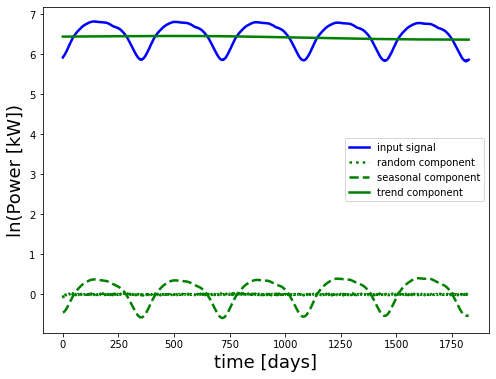

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_power, color="blue", lw=2.5, label="input signal")
ax.plot(random, color="green", ls=":", lw=2.5, label="random component")
ax.plot(seasonal, color="green", ls="--", lw=2.5, label="seasonal component")
ax.plot(trend, color="green", ls="-", lw=2.5, label="trend component")
ax.set_ylabel("ln(Power [kW])", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
ax.legend()

Text(0.5, 0, 'time [days]')

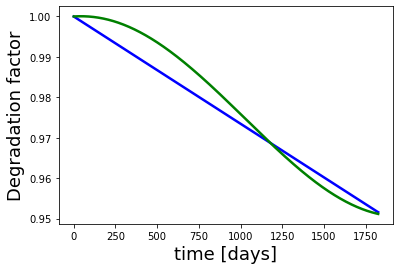

In [122]:
fig, ax = plt.subplots()
ax.plot(df_basic.Degradation.to_numpy(), color="blue", lw=2.5)
ax.plot(eta_d_pred_0, color="green", lw=2.5)
ax.set_ylabel("Degradation factor", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)

**Final step: Calculate degradation factor**

First, we use batch gradient descent to fit a line to the predicted degradation factor. 
Then, we can use the following equation to convert degradation factor $\eta_{d}$ into a degradation rate $r_d$:
\begin{equation}
\eta_d(t) = 1 +r_d\cdot t,
\end{equation}
where $t$ is the time given in years. This equation holds since the true degradation rate $r_d^{\rm true}$ is constant over the whole time series.

In [117]:
# m denotes the number of examples
def gradientDescent(x, y, theta, alpha, m, numIterations=100000):
    """
    Batch gradient descent for linear regression
    """
    for i in range(0, numIterations):
        hypothesis = np.transpose(np.matmul(x, theta))
        #loss       = hypothesis - y
        #cost       = np.sum(loss**2)/(2*m)
        #print("Iteration %d | Cost: %f" % (i, cost))
        theta      = theta - alpha/m*np.transpose(np.matmul(hypothesis - y, x))
    return theta

In [125]:
x          = np.arange(1, len(trend)+1, 1)
x_copy     = np.concatenate((np.ones(len(trend)), x))
x_copy     = np.transpose(x_copy.reshape(2, len(trend)))
y          = eta_d_pred_0
y          = np.array(y, ndmin=2)

theta      = np.array([[1], [0]])
theta      = gradientDescent(x_copy, y, theta, 1e-7, len(trend), numIterations=1000)
eta_d_pred = np.matmul(x_copy, theta)

(1826, 1)


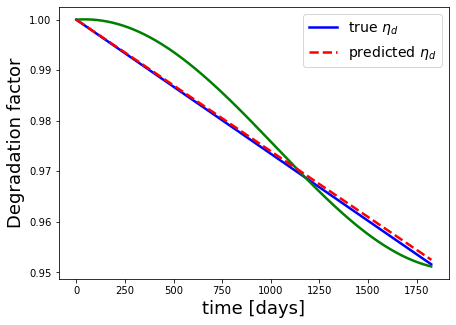

In [128]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(df_basic.Degradation.to_numpy(), color="blue", lw=2.5, label=r"true $\eta_d$")
ax.plot(eta_d_pred_0, color="green", lw=2.5)
ax.plot(x, eta_d_pred, color="red", ls="--", lw=2.5, label=r"predicted $\eta_d$")

ax.set_ylabel("Degradation factor", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
ax.legend(fontsize=14)

In [149]:
time     = np.arange(1, len(eta_d_pred) + 1, 1) # [days]
time     = time/365. # [years]
r_d_pred = np.divide(eta_d_pred[:, 0] - 1, time)
r_d_true = np.divide(df_basic.Degradation.to_numpy() - 1, time)
print (np.min(r_d_pred), np.max(r_d_pred))

-0.00950244658806982 -0.00944721997981568


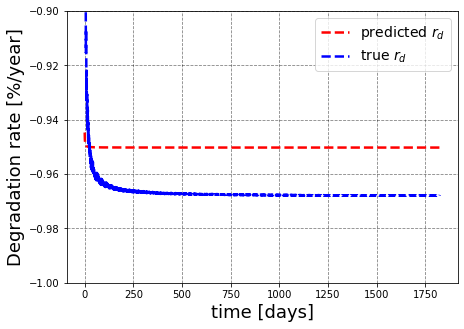

In [157]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(r_d_pred*100, color="red", ls="--", lw=2.5, label="predicted $r_d$")
ax.plot(r_d_true*100, color="blue", ls="--", lw=2.5, label="true $r_d$")
ax.set_xlabel("time [days]", fontsize=18)
ax.set_ylabel("Degradation rate [%/year]", fontsize=18)
ax.set_ylim([-1, -0.9])
ax.legend(fontsize=14)
ax.grid(ls="--", color="k", alpha=0.5)

- Why I obtain the weird behaviour for the true degradation factor?